In [1]:
#pip install numpy==1.24.4 pandas==1.5.3 pyarrow==12.0.1 stumpy==1.12.0 tsfresh==0.20.1 xgboost==1.7.6 catboost==1.2 lightgbm==4.0.0 hyperopt==0.2.7 optuna==3.3.0 mlflow==2.6.0 shap==0.42.1


## Исследование временных рядов с Pyspark: Прогнозирование заказов в районах Чикаго



| №  | Название столбцов             | Описание                                                                                                                                                                                                                                             | Тип данных с сайта |
|----|-------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------|
| 1  | Trip ID                       | Уникальный идентификатор поездки.                                                                                                                                                                                                                    | Text               |
| 2  | Taxi ID                       | Уникальный идентификатор для такси.                                                                                                                                                                                                                  | Text               |
| 3  | Trip Start Timestamp          | Когда началась поездка, округлено до ближайших 15 минут                                                                                                                                                                                               | Date & Time        |
| 4  | Trip End Timestamp            | Когда поездка закончилась, округлено до ближайших 15 минут.                                                                                                                                                                                          | Date & Time        |
| 5  | Trip Seconds                  | Время поездки в секундах.                                                                                                                                                                                                                            | Number             |
| 6  | Trip Mile                     | Расстояние поездки в милях.                                                                                                                                                                                                                          | Number             |
| 7  | Pickup Census Tract           | Район, с которого началась поездка. В целях конфиденциальности этот переписной участок не отображается для некоторых поездок. Для мест за пределами Чикаго этот столбец часто остается пустым.                                                        | Text               |
| 8  | Dropoff Census Tract          | Район, на котором завершилась поездка. В целях конфиденциальности этот переписной участок не отображается для некоторых поездок. Для мест за пределами Чикаго этот столбец часто остается пустым.                                                      | Text               |
| 9  | Pickup Community Area         | Район сообщества, с которого началась поездка. В этом столбце будут указаны места за пределами Чикаго. Пустыми будут указаны места за пределами Чикаго.                                                                                                | Number             |
| 10 | Dropoff Community Area        | Район сообщества, где закончилась поездка. В этом столбце будут указаны места за пределами Чикаго. Пустым.                                                                                                                                            | Number             |
| 11 | Fare                          | Стоимость поездки.                                                                                                                                                                                                                                   | Number             |
| 12 | Tips                          | Чаевые за поездку. Чаевые наличными, как правило, не учитываются.                                                                                                                                                                                    | Number             |
| 13 | Tolls                         | Плата за поездку.                                                                                                                                                                                                                                    | Number             |
| 14 | Extras                        | Дополнительная плата за поездку.                                                                                                                                                                                                                     | Number             |
| 15 | Trip Total                    | Общая стоимость поездки, общая сумма по предыдущим столбцам.                                                                                                                                                                                         | Number             |
| 16 | Payment Type                  | Тип оплаты за поездку.                                                                                                                                                                                                                               | Text               |
| 17 | Company                       | Таксомоторная компания.                                                                                                                                                                                                                              | Text               |
| 18 | Pickup Centroid Latitude      | Широта места или района сообщества, если участок переписи был скрыт в целях конфиденциальности. Этот столбец часто остается пустым для местоположений за пределами Чикаго.                                                                           | Number             |
| 19 | Pickup Centroid Longitude     | Долгота места или района сообщества, если участок переписи был скрыт в целях конфиденциальности. Этот столбец часто остается пустым для местоположений за пределами Чикаго.                                                                          | Number             |
| 20 | Pickup Centroid Location      | Местоположение центра места или района Чикаго, если участок переписи был скрыт в целях конфиденциальности. Этот столбец часто остается пустым для местоположений за пределами Чикаго.                                                                | Point              |
| 21 | Dropoff Centroid Latitude     | Широта места высадки, если район Чикаго был скрыт в целях конфиденциальности. Этот столбец часто остается пустым для местоположений за пределами Чикаго.                                                                                              | Number             |
| 22 | Dropoff Centroid Longitude    | Долгота места, предназначенного для высадки, или района Чикаго, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто остается пустым для местоположений за пределами Чикаго.                                              | Number             |
| 23 | Dropoff Centroid Location     | Местоположение центра места, предназначенного для высадки, или района Чикаго, если переписной участок был скрыт в целях конфиденциальности. Этот столбец часто остается пустым для мест за пределами Чикаго.                                           | Point              |

### Библиотеки 

In [2]:
!pip install folium
!pip install mlflow 
!pip install shap
!pip install geopandas
!pip install hyperopt
!pip install xgboost
!pip install pyspark
!pip install optuna
!pip install catboost

In [3]:
# Библиотеки для работы с данными
import pandas as pd 
import numpy as np

# Графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime

# Библиотеки и инструменты для работы с Spark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.window import Window

# Инструменты для анализа временных рядов
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Библиотеки и инструменты для машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor, Pool

# Инструменты для оптимизации и настройки гиперпараметров
import optuna

# Инструменты для работы с моделями в Spark
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.sql.functions import percent_rank, lit, row_number
from pyspark.sql.window import Window

# Вспомогательные константы
RANDOM_SEED = 42


In [4]:
# import py4j
# print(py4j.__version__)

**Проверка**

In [5]:
# запуск spark-сессии 2
SPARK_MASTER_IP = '172.18.0.2' 
spark = SparkSession.builder.appName("pyspark-taxi-forecasting")\
.master(f"spark://{SPARK_MASTER_IP}:7077")\
.config("spark.executor.cores", 1)\
.config("spark.task.cpus", 1)\
.getOrCreate()

In [6]:
spark

In [7]:
schema = StructType([
    StructField('Trip ID', StringType(), nullable=True),
    StructField('Taxi ID', StringType(), nullable=True),
    StructField('Trip Start Timestamp', StringType(), nullable=True),
    StructField('Trip End Timestamp', StringType(), nullable=True),
    StructField('Trip Seconds', IntegerType(), nullable=True),
    StructField('Trip Miles', FloatType(), nullable=True),
    StructField('Pickup Census Tract', StringType(), nullable=True),
    StructField('Dropoff Census Tract', StringType(), nullable=True),
    StructField('Pickup Community Area', IntegerType(), nullable=True),
    StructField('Dropoff Community Area', IntegerType(), nullable=True),
    StructField('Fare', FloatType(), nullable=True),
    StructField('Tips', FloatType(), nullable=True),
    StructField('Tolls', FloatType(), nullable=True),
    StructField('Extras', FloatType(), nullable=True),
    StructField('Trip Total', FloatType(), nullable=True),
    StructField('Payment Type', StringType(), nullable=True),
    StructField('Company', StringType(), nullable=True),
    StructField('Pickup Centroid Latitude', FloatType(), nullable=True),
    StructField('Pickup Centroid Longitude', FloatType(), nullable=True),
    StructField('Pickup Centroid Location', StringType(), nullable=True),
    StructField('Dropoff Centroid Latitude', FloatType(), nullable=True),
    StructField('Dropoff Centroid Longitude', FloatType(), nullable=True),
    StructField('Dropoff Centroid  Location', StringType(), nullable=True)
])

In [8]:
# загрузка данных

try:
    df_22 = spark.read.csv('Taxi_Trips_-_2022.csv', header=True, schema=schema)
    df_23 = spark.read.csv('Taxi_Trips_-_2023.csv', header=True, schema=schema)
    print('Данные загружены корректно')
except:
    print('Данные не доступны')
    raise SystemExit(0)

Данные загружены корректно


__Сравнение признаков:__

In [9]:
# получение признаков из df_22 и df_23
columns_df_22 = df_22.columns
columns_df_23 = df_23.columns

# сравнение признаков
common_columns = set(columns_df_22) & set(columns_df_23)
unique_columns_df_22 = set(columns_df_22) - common_columns
unique_columns_df_23 = set(columns_df_23) - common_columns

# вывод результатов
print(f'Общие признаки: {common_columns}')
print(f'Признаки уникальные для df_22: {unique_columns_df_22}')
print(f'Признаки уникальные для df_23: {unique_columns_df_23}')

Общие признаки: {'Trip End Timestamp', 'Pickup Census Tract', 'Dropoff Centroid Longitude', 'Pickup Community Area', 'Pickup Centroid Location', 'Trip Miles', 'Payment Type', 'Trip Start Timestamp', 'Fare', 'Dropoff Community Area', 'Pickup Centroid Latitude', 'Extras', 'Dropoff Census Tract', 'Trip Seconds', 'Company', 'Pickup Centroid Longitude', 'Dropoff Centroid  Location', 'Trip Total', 'Taxi ID', 'Dropoff Centroid Latitude', 'Tips', 'Tolls', 'Trip ID'}
Признаки уникальные для df_22: set()
Признаки уникальные для df_23: set()


- Результаты сравнения признаков говорят о том, что оба набора данных (df_22 и df_23) имеют одинаковые признаки, и в них нет уникальных признаков для каждого года. 

Из всех признаков нам необходимы:
- `Trip Start Timestamp`: Время начала поездки, округленное до ближайших 15 минут.
- `Pickup Community Area`: Общественная территория, с которой началась поездка. Этот признак указывает на округ (community area), в котором началась поездка.
- (пропуски обозначаюз поездки за пределами города)

__Проверка данных на наличие дубликатов__

In [10]:
def duplicates(df):
    duplicates = df.groupBy(df.columns).count().filter(F.col('count') > 1)
    if duplicates.count() > 0:
        print('Обнаружены дубликаты:')
        duplicates.show()
    else: print('Дубликаты отсутствуют')

In [11]:
# проверка данных за 2022г.
duplicates(df_22)

Дубликаты отсутствуют


In [12]:
# проверка данных за 2023г.
duplicates(df_23)

Дубликаты отсутствуют


__Объединение датасетов__

In [13]:
# исходный размер датасетов
print(f'Количество строк в df_22: {df_22.count()}')
print(f'Количество строк в df_23: {df_23.count()}')

Количество строк в df_22: 6382425
Количество строк в df_23: 4337597


In [14]:
# выбор признаков `Trip Start Timestamp` и `Pickup Community Area` из df_22
df_22_selected = df_22.select('Trip Start Timestamp', 'Pickup Community Area')

# выбор признаков `Trip Start Timestamp` и `Pickup Community Area` из df_23
df_23_selected = df_23.select('Trip Start Timestamp', 'Pickup Community Area')

# объединение данных df_22 и df_23
df = df_22_selected.union(df_23_selected)

In [15]:
# проверка корректности объединения данных
if df.count() == df_22.count() + df_23.count():
    print('Данные объеденены корректно')
else: print('Данные объеденены некорректно')

Данные объеденены корректно


__Обработка пропусков__

Пропуски в текущих данных означают поездки за городом

In [16]:
# удаление записей с пропусками из датафрейма
df_cleaned = df.na.drop(how='any')

# количество строк до и после удаления пропусков
print(f'Количество строк до удаления пропусков: {df.count()}')
print(f'Количество строк после удаления пропусков: {df_cleaned.count()}')

Количество строк до удаления пропусков: 10720022
Количество строк после удаления пропусков: 10022079


__Типы данных__

In [17]:
df_cleaned.printSchema()

root
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)



In [18]:
# преобразование рпизнака `Trip Start Timestamp` в тип данных timestamp
df = df_cleaned.withColumn('Trip Start Timestamp', F.to_timestamp(
    F.col('Trip Start Timestamp'), 'MM/dd/yyyy hh:mm:ss a'))

In [19]:
# округление времени до ближайшего часа
df = df.withColumn('Trip Start Timestamp', F.date_trunc('hour', 'Trip Start Timestamp'))

In [20]:
# агрегация данных и подсчет количества одинаковых строк
agg_df = df.groupBy('Trip Start Timestamp', 'Pickup Community Area')\
               .agg(F.count('*').alias('count'))

# переименование столбцов
agg_df = agg_df.withColumnRenamed('Trip Start Timestamp', 'time')\
                    .withColumnRenamed('Pickup Community Area', 'area')

# просмотр первых 5-ти записей в агрегированном датафрейме
agg_df.show(5)

+-------------------+----+-----+
|               time|area|count|
+-------------------+----+-----+
|2022-02-28 12:00:00|   8|  165|
|2022-02-28 14:00:00|  69|    6|
|2022-02-28 15:00:00|   5|    5|
|2022-02-28 15:00:00|  46|    4|
|2022-03-01 01:00:00|  69|    1|
+-------------------+----+-----+
only showing top 5 rows



In [21]:
# подсчет количества уникальных значений в столбце `area`
unique_areas_count = agg_df.select('area').distinct().count()
print(f'Количество уникальных значений в столбце `area`: {unique_areas_count}')

Количество уникальных значений в столбце `area`: 77


- У нас представленны данные по 77, что соответствует реальному количеству округов.

__Проверим хронологический порядок данных:__

In [22]:
def num_out_of_order_areas(df):
    # оконная функция для сортировки данных по времени внутри каждого округа
    window_spec = Window.partitionBy('area').orderBy('time')
    # сортировка данных
    sorted_df = agg_df.withColumn('sorted', F.row_number().over(window_spec))
    # проверка хронологии данных для каждого округа
    sorted_df = sorted_df.filter(F.col('sorted') > 1)
    # подсчет количества округов, где хронология нарушена
    sorted_df = sorted_df.select('area').distinct()
    count = sorted_df.count()
    sorted_df = None
    return count

In [23]:
print(f'Количество округов, где хронология нарушена: {num_out_of_order_areas(agg_df)}')

Количество округов, где хронология нарушена: 77


- В каждом округе, за время наблюдения, случалиси часы в которые небыло заказов такси, необходимо восстановить эти данные. отобразив нулевое количество заказов

In [24]:
# поиск минимального и максимального значения времени в agg_df
min_time = agg_df.select(F.min('time')).first()[0]
max_time = agg_df.select(F.max('time')).first()[0]

# создание временного ряда
time_range = [(min_time + timedelta(hours=i)) for i in range(int((max_time - min_time).total_seconds() / 3600) + 1)]

# создание DataFrame с временным рядом
time_series_df = spark.createDataFrame([(t,) for t in time_range], ['time'])

# создание DataFrame с уникальными округами
unique_areas_df = agg_df.select('area').distinct()

# добавление столбца time к каждому округу
full_data = unique_areas_df.crossJoin(time_series_df)

# присоединение агрегированных данных к полному временному ряду
result_df = full_data.join(agg_df, ['time', 'area'], 'left').fillna(0, subset=['count'])

Проверим корректность восстановления хронологических данных:
  - Сумма заказов исходных данных должна совпадать с суммой заказов в данных с восстановленным хронологическим порядком.

In [25]:
result_df

DataFrame[time: timestamp, area: int, count: bigint]

In [26]:
if result_df.agg(F.sum('count')).collect()[0][0] == agg_df.agg(F.sum('count')).collect()[0][0]:
    print('Хронологический порядок данных востановлен корректно')
else: print('Данные искаженны')

Хронологический порядок данных востановлен корректно


In [27]:
result_df.describe('count').show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|           1123661|
|   mean| 8.919130413888174|
| stddev|35.229762945996434|
|    min|                 0|
|    max|               591|
+-------+------------------+



**Детальный анализ сводной статистики заказов такси в Чикаго**

Исходя из предоставленной сводной статистики, можно сделать следующие выводы:

1. **Общая активность:** 
    - Всего в датасете представлено 1,123,661 записей о заказах такси.
    - Среднее количество заказов составляет приблизительно 8.92 заказа.
  
2. **Изменчивость заказов:** 
    - Стандартное отклонение равно 35.23, что указывает на высокую изменчивость количества заказов. Это может быть связано с различными факторами, такими как время суток, день недели или погодные условия.
  
3. **Минимум и максимум:**
    - Есть часы или округа, где заказов такси не было вообще (минимум равен 0).
    - В то же время, максимальное количество заказов в определенный час в каком-то из округов достигло 591. Это может указывать на наличие пиковой активности или особых событий, вызывающих повышенный спрос на такси.

4. **Пики активности:**
    - Наблюдение таких высоких максимальных значений может указывать на наличие определенных паттернов или особых событий в Чикаго. Это могут быть крупные праздники, мероприятия, спортивные события или другие культурные моменты, привлекающие большое количество людей.

В заключение, анализ сводной статистики указывает на то, что спрос на такси в Чикаго довольно изменчив и может колебаться в зависимости от множества факторов. Для точного прогнозирования спроса и понимания этих паттернов необходим дальнейший анализ данных, учитывая временные рамки, погодные условия и возможные события в городе.


__Зависимость среднего количества заказов в час от округа__

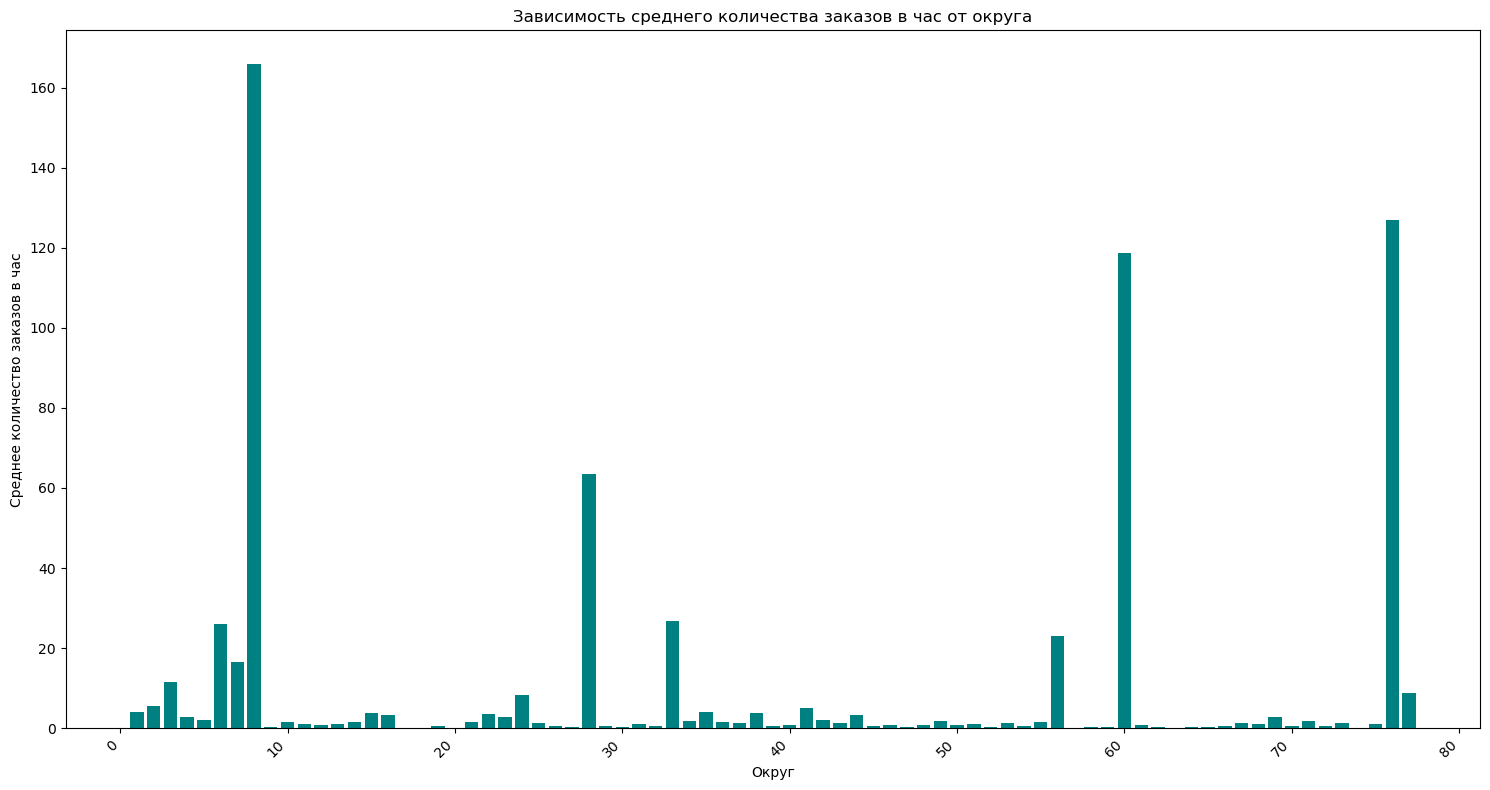

In [28]:
# группировка данных по округам и рассчет среднее количество заказов
avg_orders_by_area = result_df.groupBy('area').agg(F.mean('count').alias('avg_count'))

# получение данных для построения графика
areas = avg_orders_by_area.select('area').rdd.flatMap(lambda x: x).collect()
avg_counts = avg_orders_by_area.select('avg_count').rdd.flatMap(lambda x: x).collect()

# построение графика
plt.figure(figsize=(15, 8))
plt.bar(areas, avg_counts, color='teal')
plt.xlabel('Округ')
plt.ylabel('Среднее количество заказов в час')
plt.title('Зависимость среднего количества заказов в час от округа')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Детальный анализ разброса среднего количества заказов по округам и часам в Чикаго**

1. **Неравномерное распределение заказов:** 
    - Разные округа Чикаго имеют свои уникальные характеристики, что может привести к различиям в потребностях транспорта. Бизнес-районы могут иметь пики активности в начале и конце рабочего дня, тогда как туристические районы - вечером.

2. **Влияние времени суток:** 
    - Спрос на такси может меняться в зависимости от времени суток. Например, утром люди коммутируют на работу, а вечером - возвращаются домой или отправляются на отдых.

3. **Планирование ресурсов:** 
    - Зная паттерны спроса, службы такси могут эффективнее распределять автомобили по городу, чтобы уменьшить время ожидания для клиентов.

4. **Маркетинг и продвижение:** 
    - Округа с низкой активностью могут служить целевой аудиторией для маркетинговых кампаний с целью увеличения осведомленности и использования услуг такси.

5. **Инфраструктурные решения:** 
    - Анализируя активность по различным округам, город может принимать решения о размещении такси-стоянок, планировании транспортных маршру


__Зависимость среднего количества заказов такси от часа__

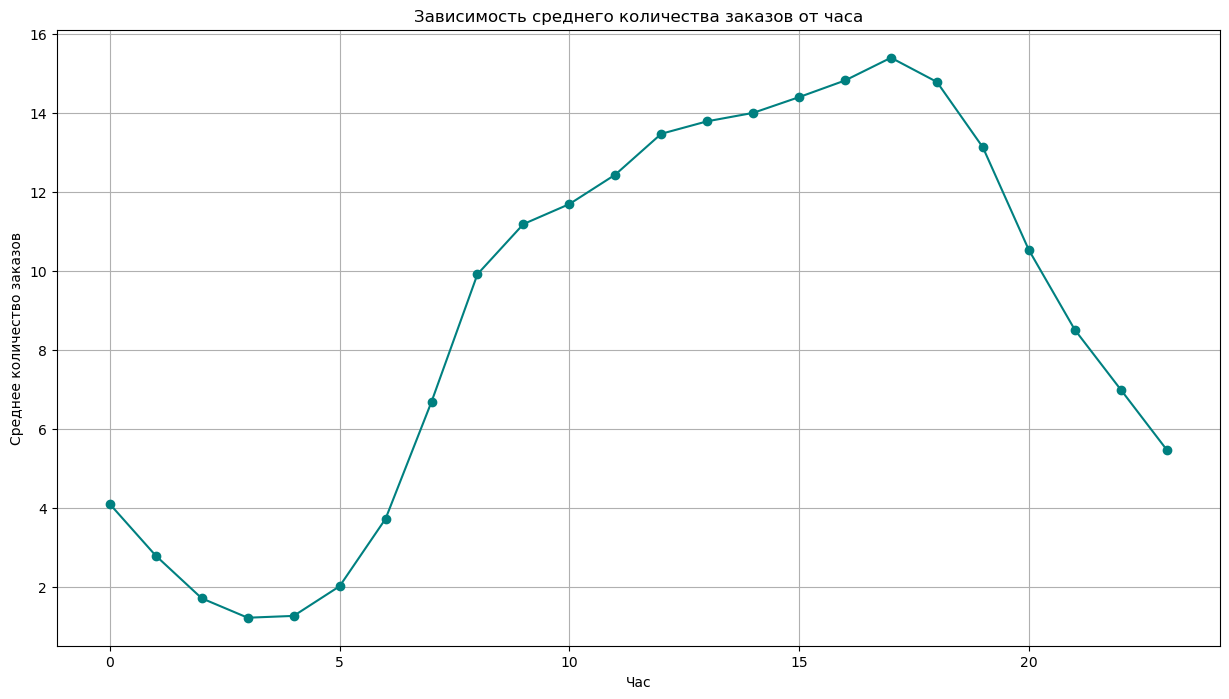

In [29]:
# рассчет признака с часом
result_df_with_hour = result_df.withColumn('hour', F.hour('time'))

# рассчет среднего количество заказов по часам
avg_counts_by_hour = result_df_with_hour.groupBy('hour').agg(F.avg('count').alias('avg_count')).orderBy('hour')
avg_counts_by_hour_pd = avg_counts_by_hour.toPandas()

# построение графика
plt.figure(figsize=(15, 8))
plt.plot(avg_counts_by_hour_pd['hour'], avg_counts_by_hour_pd['avg_count'], marker='o', color='teal')
plt.title('Зависимость среднего количества заказов от часа')
plt.xlabel('Час')
plt.ylabel('Среднее количество заказов')
plt.grid(True)
plt.show()

- Из графика и данных видно, что среднее количество заказов такси в Чикаго имеет характерный пик в период с 16 до 18 часов, что, вероятно, связано с концом рабочего дня и повышенным спросом

__Зависимость среднего количества заказов такси от дня недели__

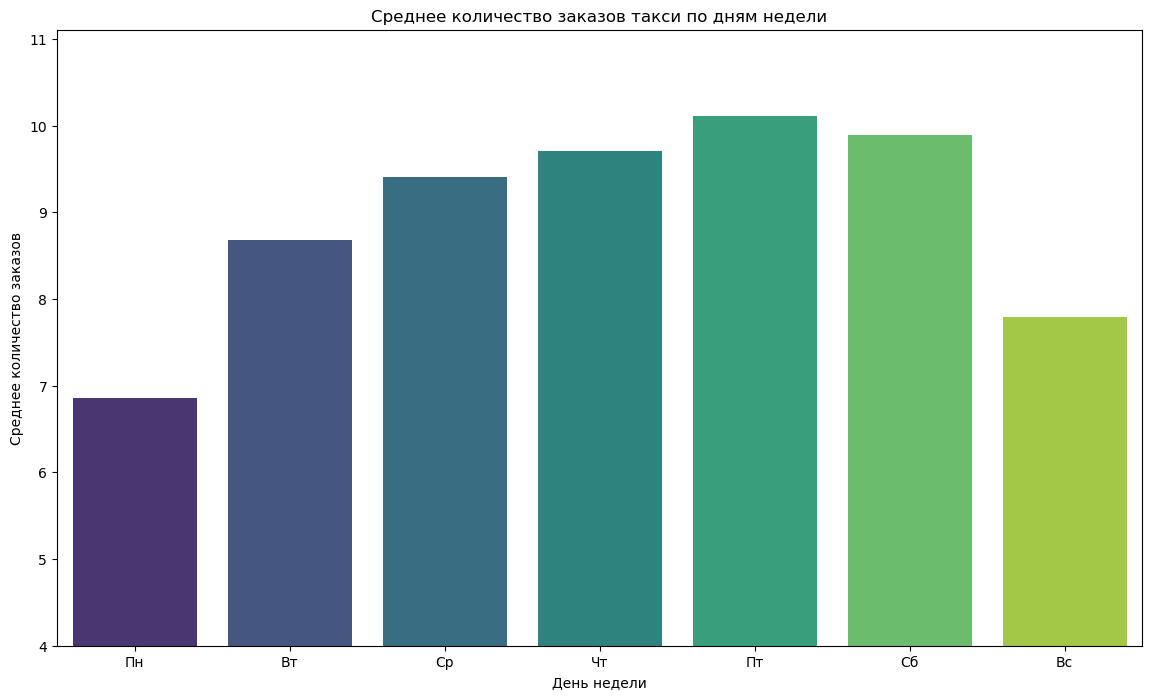

In [30]:

# рассчет среднего количества заказов такси по дням недели
avg_counts_by_weekday = result_df.groupBy(F.dayofweek('time').alias('weekday')).avg('count').orderBy('weekday')

# подготовка данных
weekdays = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
avg_counts_df = avg_counts_by_weekday.toPandas()
avg_counts_df['weekday'] = weekdays

# построение графика с помощью seaborn
plt.figure(figsize=(14, 8))
sns.barplot(x='weekday', y='avg(count)', data=avg_counts_df, palette='viridis')
plt.xlabel('День недели')
plt.ylabel('Среднее количество заказов')
plt.title('Среднее количество заказов такси по дням недели')
plt.ylim(4, max(avg_counts_df['avg(count)']) + 1)  # установлено начальное значение оси Y на 4
plt.show()


**Детализированный анализ зависимости среднего количества заказов такси от дня недели в Чикаго**

1. **Активные дни:** 
    - Четверг, пятница и суббота являются наиболее активными днями для заказов такси. Это может указывать на повышенную социальную и культурную активность горожан в эти дни.

2. **Вечерние и ночные мероприятия:** 
    - В конце недели много вечерних мероприятий, таких как концерты, представления, кино и ночные клубы. Это может привести к повышенному спросу на такси, особенно в поздние часы.

3. **Выходные и отдых:** 
    - В пятницу многие люди завершают рабочую неделю и стремятся провести время вне дома, что может увеличивать спрос на транспортные услуги.

4. **Туристическая активность:** 
    - Выходные дни могут привлекать больше туристов в город, что также увеличивает спрос на такси.

5. **Рабочая неделя:** 
    - В начале недели (воскресенье, понедельник) спрос на такси может быть ниже из-за меньшей социальной активности и того, что многие люди проводят время дома, отдыхая после активных выходных.

В заключение, анализ заказов такси по дням недели может помочь службам такси в прогнозировании спроса и эффективном планировании ресурсов.


__Зависимость среднего количества заказов такси от месяца года__

/tmp/ipykernel_384982/3619927459.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis))


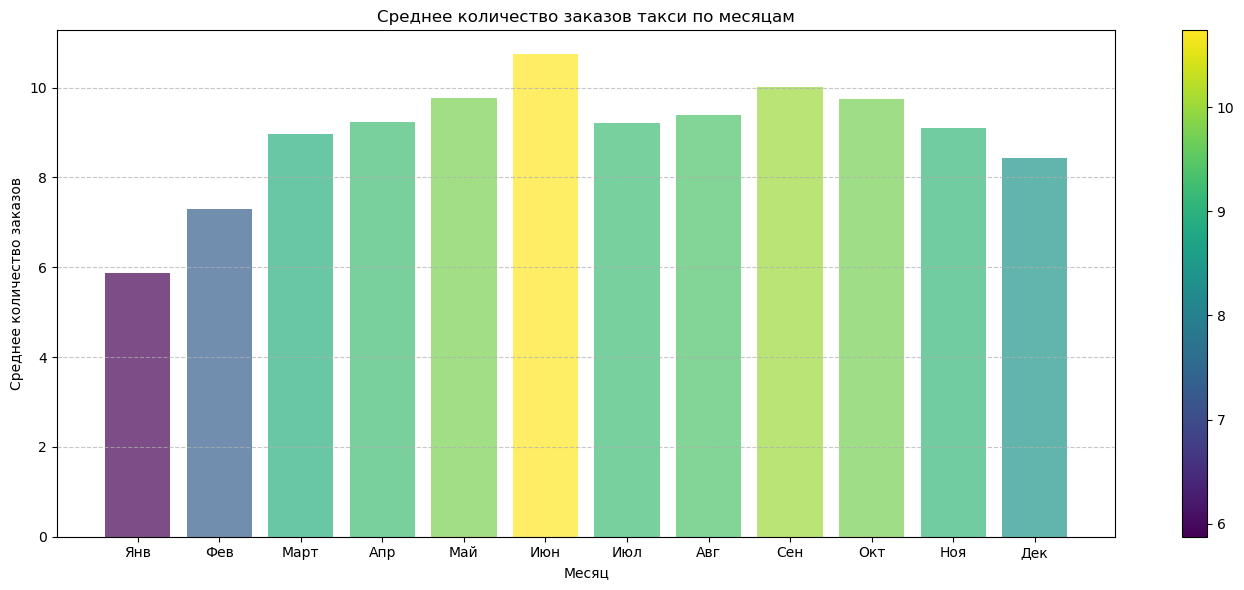

In [31]:
# рассчет среднего количества заказов по месяцам
avg_counts_by_month = result_df.groupBy(F.month('time').alias('month'))\
                               .agg(F.avg('count').alias('avg_count')).orderBy('month')

months = [row.month for row in avg_counts_by_month.select('month').collect()]
avg_counts = [row.avg_count for row in avg_counts_by_month.select('avg_count').collect()]

# Нормализация данных для задания цвета
norm = plt.Normalize(min(avg_counts), max(avg_counts))
colors = plt.cm.viridis(norm(avg_counts))

# построение графика
plt.figure(figsize=(14, 6))
bars = plt.bar(months, avg_counts, color=colors, alpha=0.7)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis))
plt.xlabel('Месяц')
plt.ylabel('Среднее количество заказов')
plt.title('Среднее количество заказов такси по месяцам')
plt.xticks(months, ['Янв', 'Фев', 'Март', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



**Детальный анализ зависимости среднего количества заказов такси от месяца в Чикаго**

1. **Пиковые месяцы:** 
    - Июнь и сентябрь являются месяцами с наивысшим средним количеством заказов. Это может быть связано с различными сезонными факторами и активностью горожан.

2. **Летний и осенний туризм:** 
    - Летом и в начале осени многие люди планируют путешествия, отпуска и поездки, что может увеличивать спрос на транспортные услуги.

3. **Сезонные мероприятия:** 
    - В теплые месяцы проводится больше культурных и социальных мероприятий на открытом воздухе, что может привести к увеличению использования такси.

4. **Зимние праздники:** 
    - Декабрь, будучи месяцем зимних праздников, может иметь меньше заказов из-за того, что многие люди проводят время с семьей, уезжают на отпуск или просто предпочитают оставаться дома из-за холодной погоды.

5. **Экономические и социокультурные факторы:** 
    - Различные мероприятия, конференции, фестивали и другие события, проводимые в городе, могут оказывать влияние на спрос на такси в определенные месяцы.

В заключение, анализируя месячные тренды, можно получить понимание сезонных паттернов и особенностей спроса на такси, что поможет службам такси в прогнозировании и планировании ресурсов.


## Визуализация трендов и сезонности 



In [32]:
# агрегация данных по дате
agg_result = result_df.groupBy('time').agg(F.avg('count').alias('avg_count'))
# преобразование Pandas DataFrame для декомпозиции
agg_result = agg_result.select('time', 'avg_count').toPandas()
# установка столбеца `time` как индекс
agg_result.set_index('time', inplace=True)
# сортировка данных
agg_result = agg_result.sort_index(ascending=True)
# вывод данных
display(agg_result.head(2))

,avg_count
time,
2022-01-01 00:00:00,5.727273
2022-01-01 01:00:00,7.402597


In [33]:
# проверка хронологии данных
if agg_result.index.is_monotonic_increasing:
    print('Данные представлены в хронологическом порядке')
else: print('Хронологический порядок в данных нарушен')

Данные представлены в хронологическом порядке


In [34]:
# декомпозиция
decomposition = seasonal_decompose(agg_result)

__Тренд всего временного ряда__

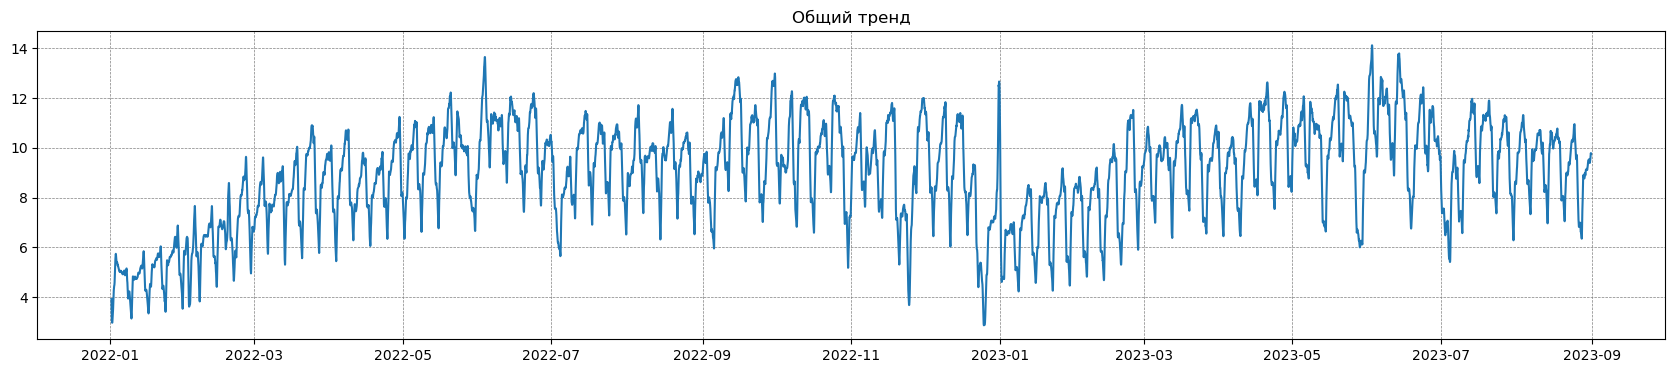

In [35]:
# визуализизвция тренда всего временного ряда
plt.figure(figsize=(21, 4))
plt.plot(decomposition.trend)
plt.title('Общий тренд')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

__Тренд, сезонность, остатки временного ряда за последний месяц__

In [36]:
print(f'Данные представленны в промежутке от {agg_result.index.min()} до {agg_result.index.max()}')

Данные представленны в промежутке от 2022-01-01 00:00:00 до 2023-09-01 00:00:00


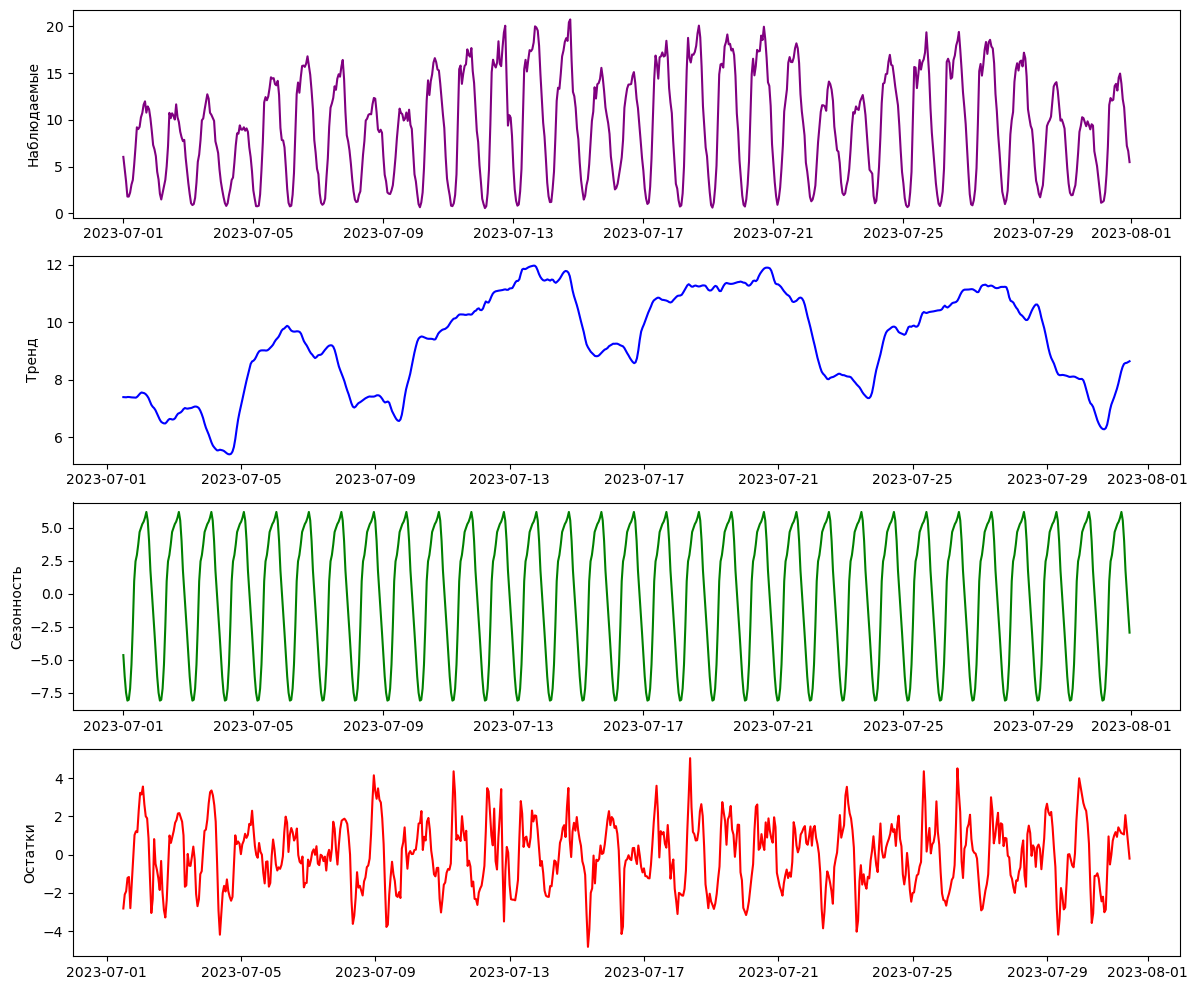

In [37]:
decomposition = seasonal_decompose(agg_result['2023-07':'2023-07'])

plt.figure(figsize=(12, 10))

# Наблюдаемые (сиреневый)
plt.subplot(4, 1, 1)
plt.plot(agg_result['2023-07':'2023-07'].index, decomposition.observed, color='purple')
plt.ylabel('Наблюдаемые')

# Тренд (синий)
plt.subplot(4, 1, 2)
plt.plot(agg_result['2023-07':'2023-07'].index, decomposition.trend, color='blue')
plt.ylabel('Тренд')

# Сезонность (зеленый)
plt.subplot(4, 1, 3)
plt.plot(agg_result['2023-07':'2023-07'].index, decomposition.seasonal, color='green')
plt.ylabel('Сезонность')

# Остатки (красный)
plt.subplot(4, 1, 4)
plt.plot(agg_result['2023-07':'2023-07'].index, decomposition.resid, color='red')
plt.ylabel('Остатки')

plt.tight_layout()
plt.show()


На анализе общего тренда видны следующие особенности:

1. **Недельная сезонность**: Наблюдаются регулярные паттерны, которые повторяются каждую неделю. Это может свидетельствовать о повышенной активности заказов такси в определённые дни недели, например, в выходные.

2. **Суточная сезонность**: В течение каждого дня можно наблюдать пики и провалы активности. Это указывает на различное количество заказов такси в разное время суток. Особенно заметны пики в дневные часы, что может быть связано с рабочим графиком людей, коммерческой активностью или другими дневными мероприятиями.

3. **Тренд на увеличение**: В целом, можно заметить тренд на увеличение числа заказов со временем, что может быть связано с ростом популярности услуги или ростом населения города.

Для более глубокого понимания потребуется дополнительный анализ, возможно, с привлечением дополнительных данных о городе, праздниках, мероприятиях и других факторах, которые могут влиять на спрос на такси.


__Проверка приводимости временного ряда к стационарному__

In [38]:
ts = agg_result['avg_count']
st_test = adfuller(ts, regression='ctt')
# если значение с индексом 1 меньше P-Value (0.05), то ряд приводим к стационарному
if st_test[1] < 0.05: print('Временной ряд приводим к стационарному')
else: print('Временной ряд не может быть приведен к стационарному')

Временной ряд приводим к стационарному


**Анализ временных признаков и их значимость для прогнозирования**

1. **Основные временные признаки:**
    - В данных присутствует суточная, недельная и месячная сезонность. Поэтому основными временными признаками для нас являются: час, день недели и месяц. Учитывая, что у нас данные за не полные два года, значение года может быть исключено из рассмотрения из-за отсутствия его явной сезонности.

2. **Лаги:**
    - Основываясь на суточной и недельной сезонности, введем следующие лаги:
        - 24-й лаг, который будет отражать суточную сезонность.
        - 168-й лаг, чтобы учесть недельную сезонность.

3. **Скользящее среднее:** 
    - Используем скользящее среднее за неделю и месяц, чтобы учесть краткосрочные и долгосрочные тренды в данных.

4. **Средние значения по округам:** 
    - Изучение среднего количества заказов по различным округам может помочь выявить особенности спроса в разных районах города, что может быть полезной информацией для улучшения прогноза.

Используя эти признаки, можно создать более детализированную и точную модель прогнозирования, которая учитывает различные аспекты данных.


__Признаки с часом, днем недели, месяцем и годом__

In [39]:
result_df = result_df.withColumn('hour', F.hour('time')) \
                     .withColumn('dayofweek', F.dayofweek('time')) \
                     .withColumn('month', F.month('time')) \
                     .withColumn('year', F.year('time'))

# обновленный датасет
result_df.show(2)

+-------------------+----+-----+----+---------+-----+----+
|               time|area|count|hour|dayofweek|month|year|
+-------------------+----+-----+----+---------+-----+----+
|2022-01-01 00:00:00|  65|    0|   0|        7|    1|2022|
|2022-05-09 00:00:00|  31|    0|   0|        2|    5|2022|
+-------------------+----+-----+----+---------+-----+----+
only showing top 2 rows



__Лаги__

In [40]:
# задаем количество лагов
max_lag = 168
# окно для разбиения по округам и упорядочивания по времени
window_spec = Window().partitionBy('area').orderBy('time')
# добавляем лаги для каждого округа
for lag in range(1, max_lag + 1):
    lag_col_name = 'lag_{}'.format(lag)
    result_df = result_df.withColumn(lag_col_name, F.lag('count', lag).over(window_spec))

Давайте проверим количество пропущенных значений в лагах:

- Для первого лага ожидаемое количество пропущенных значений составляет \(1 \times 77\) округов, что равно 77.
- Для 168-го лага ожидаемое количество пропущенных значений составляет \(168 \times 77\) округов, что равно 12,936.


In [41]:
result_df.select(F.sum(F.col('lag_1').isNull().cast('int'))).show()

+---------------------------------+
|sum(CAST((lag_1 IS NULL) AS INT))|
+---------------------------------+
|                               77|
+---------------------------------+



In [42]:
result_df.select(F.sum(F.col('lag_168').isNull().cast('int'))).show()

+-----------------------------------+
|sum(CAST((lag_168 IS NULL) AS INT))|
+-----------------------------------+
|                              12936|
+-----------------------------------+



- Лаги созданы корректно.

__Скользяшее среднее за неделю и месяц__
- Необходимо учесть, что бы данные не включали текущую дату.

In [43]:
# окно для вычисления скользящего среднего за неделю (7 дней)
week_window = Window.partitionBy('area').orderBy('time').rowsBetween(-192, -24)

# окно для вычисления скользящего среднего за месяц (30 дней)
month_window = Window.partitionBy('area').orderBy('time').rowsBetween(-744, -24)

# вычисление скользящего среднего за неделю и месяц
result_df = result_df.withColumn('avg_week', F.avg('count').over(week_window))
result_df = result_df.withColumn('avg_month', F.avg('count').over(month_window))

__Среднее значение заказов по округам за все время__

In [44]:
# окно для группировки по округам
window_spec = Window.partitionBy('area')

# добавление столбца среднего значения заказов по округам за все время
result_df = result_df.withColumn('avg_count_all_time',F.avg('count').over(window_spec))

In [45]:
# удаляем строк с пропущенными значениями
result_df = result_df.dropna()

In [46]:
result_df

DataFrame[time: timestamp, area: int, count: bigint, hour: int, dayofweek: int, month: int, year: int, lag_1: bigint, lag_2: bigint, lag_3: bigint, lag_4: bigint, lag_5: bigint, lag_6: bigint, lag_7: bigint, lag_8: bigint, lag_9: bigint, lag_10: bigint, lag_11: bigint, lag_12: bigint, lag_13: bigint, lag_14: bigint, lag_15: bigint, lag_16: bigint, lag_17: bigint, lag_18: bigint, lag_19: bigint, lag_20: bigint, lag_21: bigint, lag_22: bigint, lag_23: bigint, lag_24: bigint, lag_25: bigint, lag_26: bigint, lag_27: bigint, lag_28: bigint, lag_29: bigint, lag_30: bigint, lag_31: bigint, lag_32: bigint, lag_33: bigint, lag_34: bigint, lag_35: bigint, lag_36: bigint, lag_37: bigint, lag_38: bigint, lag_39: bigint, lag_40: bigint, lag_41: bigint, lag_42: bigint, lag_43: bigint, lag_44: bigint, lag_45: bigint, lag_46: bigint, lag_47: bigint, lag_48: bigint, lag_49: bigint, lag_50: bigint, lag_51: bigint, lag_52: bigint, lag_53: bigint, lag_54: bigint, lag_55: bigint, lag_56: bigint, lag_57: bi

## Выделение обучающей и тестовой выборок

In [47]:
from pyspark.ml.regression import LinearRegression as SparkLR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from pyspark.sql.functions import collect_list, row_number, monotonically_increasing_id
from pyspark.sql.window import Window
from pyspark.sql.functions import col

In [48]:

# Определение временного порога для разделения на трейн и тест
split_time_valid = datetime(2023, 5, 1, 0, 0) 
split_time_test = datetime(2023, 8, 1, 0, 0)

In [49]:

# Разделение на трейн и тест
train_data = result_df.filter(result_df['time'] < split_time_valid)
valid_data = result_df.filter((result_df['time'] >= split_time_valid) & (result_df['time'] < split_time_test))
test_data = result_df.filter(result_df['time'] >= split_time_test)

In [50]:
# train_data.head()

In [51]:
# списки категориальных и числовых признаков
categorical_cols = ['hour', 'dayofweek', 'month', 'year', 'area']
numeric_cols = ['lag_{}'.format(i) for i in range(1, 169)] + ['avg_week', 'avg_month', 'avg_count_all_time']

In [52]:
# пайплайн для категориальных признаков
indexers = [StringIndexer(inputCol=col, outputCol=col + '_index', handleInvalid='keep') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + '_index', outputCol=col + '_ohe') for col in categorical_cols]
assembler_cat = VectorAssembler(inputCols=[col + '_ohe' for col in categorical_cols], outputCol='cat_features')

In [53]:
# пайплайн для числовых признаков
assembler_num = VectorAssembler(inputCols=numeric_cols, outputCol='num_features')
scaler = StandardScaler(inputCol='num_features', outputCol='scaled_num_features', withStd=True, withMean=True)

In [54]:
# объединенние результатов пайплайнов
assembler = VectorAssembler(inputCols=['cat_features', 'scaled_num_features'], outputCol='features')
# итоговый пайплайн
pipeline = Pipeline(stages=indexers + encoders + [assembler_cat, assembler_num, scaler, assembler])

In [55]:
# Обработка признаков
pipeline = Pipeline(stages=indexers + encoders + [assembler_cat, assembler_num, scaler, assembler])
pipeline_model = pipeline.fit(train_data)
train_data_transformed = pipeline_model.transform(train_data)
valid_data_transformed = pipeline_model.transform(valid_data)
test_data_transformed = pipeline_model.transform(test_data)

In [81]:
train_data_transformed.columns

['time',
 'area',
 'count',
 'hour',
 'dayofweek',
 'month',
 'year',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'lag_25',
 'lag_26',
 'lag_27',
 'lag_28',
 'lag_29',
 'lag_30',
 'lag_31',
 'lag_32',
 'lag_33',
 'lag_34',
 'lag_35',
 'lag_36',
 'lag_37',
 'lag_38',
 'lag_39',
 'lag_40',
 'lag_41',
 'lag_42',
 'lag_43',
 'lag_44',
 'lag_45',
 'lag_46',
 'lag_47',
 'lag_48',
 'lag_49',
 'lag_50',
 'lag_51',
 'lag_52',
 'lag_53',
 'lag_54',
 'lag_55',
 'lag_56',
 'lag_57',
 'lag_58',
 'lag_59',
 'lag_60',
 'lag_61',
 'lag_62',
 'lag_63',
 'lag_64',
 'lag_65',
 'lag_66',
 'lag_67',
 'lag_68',
 'lag_69',
 'lag_70',
 'lag_71',
 'lag_72',
 'lag_73',
 'lag_74',
 'lag_75',
 'lag_76',
 'lag_77',
 'lag_78',
 'lag_79',
 'lag_80',
 'lag_81',
 'lag_82',
 'lag_83',
 'lag_84',
 'lag_85',
 'la

In [83]:
# сортировка для сохранения хронологи в данных
sorted_train_data = train_data_transformed.orderBy(F.asc('time'))
# выборка для подбора моделей
limited_df = sorted_train_data.drop('time').limit(20000)
# limited_df = sorted_train_data.drop('time')
# преобразование в объект Pandas DataFrame(проверка)
pandas_df1 = limited_df.toPandas()
display(pandas_df1.head(2))

,area,count,hour,dayofweek,month,year,lag_1,lag_2,lag_3,lag_4,...,area_index,hour_ohe,dayofweek_ohe,month_ohe,year_ohe,area_ohe,cat_features,num_features,scaled_num_features,features
0,23,0,0,7,1,2022,0,0,1,0,...,15.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 3.0, 0.0, ...","[-0.2545551173134396, -0.2545548903649075, -0....","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,18,0,0,7,1,2022,0,0,0,0,...,9.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2545551173134396, -0.2545548903649075, -0....","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Глянем размер 

In [85]:
import os

# Сохраните DataFrame во временный файл в формате Parquet
temp_path = "/tmp/temp_dataset.parquet"
sorted_train_data.write.mode("overwrite").parquet(temp_path)

# Вычислите размер файла или каталога
def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

size_in_bytes = get_size(temp_path)
print(f"Size of the dataset on disk: {size_in_bytes} bytes")


Size of the dataset on disk: 8 bytes


In [86]:
# # Ограничиваем набор данных для быстрой проверки
# limited_df = train_data_transformed.orderBy(F.asc('time')).limit(1000)
# # # limited_df = train_data_transformed
# # limited_df = train_data_transformed.orderBy(F.asc('time'))

In [87]:
def objective_lr_spark(trial):
    # Параметры подбора
    reg_param = trial.suggest_float('reg_param', 0.01, 10)
    elastic_net_param = trial.suggest_float('elastic_net_param', 0, 1)
    
    # Экземпляр модели
    model = SparkLR(regParam=reg_param, elasticNetParam=elastic_net_param)
    
    mae_scores = []
    
    # Создание временного ID для строк для последующего разделения
    limited_df_with_id = limited_df.withColumn("row_id", monotonically_increasing_id())
    
    # Определение размера каждого фолда
    total_rows = limited_df_with_id.count()
    fold_size = total_rows // 5  # Примерно, так как мы используем 5-fold CV

    # Кроссвалидация
    for fold in range(5):
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size
        # print(1)
        train_fold = limited_df_with_id.filter((col("row_id") < val_start) | (col("row_id") >= val_end))
        val_fold = limited_df_with_id.filter((col("row_id") >= val_start) & (col("row_id") < val_end))
        
        # Переименование столбца count в label
        train_fold = train_fold.withColumnRenamed("count", "label")
        val_fold = val_fold.withColumnRenamed("count", "label")
        # print(2)
        if 'features' not in train_fold.columns:
           raise ValueError("The 'features' column is missing from the training data!")
        # print(3)
        # Обучение и прогнозирование
        model_fitted = model.fit(train_fold.drop("row_id"))
        val_preds = model_fitted.transform(val_fold.drop("row_id"))
        # print(4)
        # Извлечение предсказанных и истинных значений
        if val_preds.count() == 0:
            raise ValueError("val_preds is empty!")
        if 'prediction' not in val_preds.columns or 'label' not in val_preds.columns:
            raise ValueError("val_preds does not contain required columns!")

        preds_and_labels = val_preds.select(['prediction', 'label']).rdd.map(lambda row: (row['prediction'], row['label'])).collect()
        predictions, y_val_fold = zip(*preds_and_labels)
        
        mae_fold = mean_absolute_error(y_val_fold, predictions)
        mae_scores.append(mae_fold)
    
    return np.mean(mae_scores)




In [88]:
# Установка уровня логирования
optuna.logging.set_verbosity(optuna.logging.INFO)

# Создание экземпляра study
study_lr_spark = optuna.create_study(direction='minimize')

# Запуск оптимизации с прогресс-баром
study_lr_spark.optimize(objective_lr_spark, n_trials=20, show_progress_bar=True)  #20

# Получение лучших параметров и значения
best_params_spark = study_lr_spark.best_params
best_value_spark = study_lr_spark.best_value

best_params_spark, best_value_spark


[I 2023-09-29 21:51:12,871] A new study created in memory with name: no-name-fd19d333-b950-4ff8-8e09-3e5949367b30


  0%|          | 0/10 [00:00<?, ?it/s]

1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[I 2023-09-29 22:42:51,322] Trial 0 finished with value: 1.9833195694882062 and parameters: {'reg_param': 5.0843069377198615, 'elastic_net_param': 0.524005925634928}. Best is trial 0 with value: 1.9833195694882062.
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[I 2023-09-29 23:33:42,429] Trial 1 finished with value: 1.5015768877810036 and parameters: {'reg_param': 1.3827618480300403, 'elastic_net_param': 0.18669414619447788}. Best is trial 1 with value: 1.5015768877810036.
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[I 2023-09-30 00:24:24,814] Trial 2 finished with value: 3.9718208584519674 and parameters: {'reg_param': 8.74688933744371, 'elastic_net_param': 0.9915167037774849}. Best is trial 1 with value: 1.5015768877810036.
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
[I 2023-09-30 01:14:55,431] Trial 3 finished with value: 2.0570803156417874 and parameters: {'reg_param': 6.455549830511682, 'elastic_net_param': 0.4398920862484068}. Best is trial 1 with value:

({'reg_param': 1.3827618480300403, 'elastic_net_param': 0.18669414619447788},
 1.5015768877810036)

({'reg_param': 0.12109866504313822, 'elastic_net_param': 0.553917533549124},
 1.1870959555979579

In [89]:
BEST_REG_PARAM = 0.12109866504313822
BEST_ELASTIC_NET_PARAM = 0.553917533549124


#cтолбец "count" в "label" перед обучением модели.В Spark ML, колонка label обычно используется как целевая переменная для обучения модели

- train_data_transformed = train_data_transformed.withColumnRenamed("count", "label")
- valid_data_transformed = valid_data_transformed.withColumnRenamed("count", "label")
- test_data_transformed = test_data_transformed.withColumnRenamed("count", "label")

In [92]:
train_data_transformed = train_data_transformed.withColumnRenamed("count", "label")
valid_data_transformed = valid_data_transformed.withColumnRenamed("count", "label")
test_data_transformed = test_data_transformed.withColumnRenamed("count", "label")

In [93]:
# Создание модели с лучшими параметрами
best_model = SparkLR(regParam=BEST_REG_PARAM, elasticNetParam=BEST_ELASTIC_NET_PARAM)

# Обучение модели на тренировочных данных
fitted_model = best_model.fit(train_data_transformed)

# Прогнозирование на валидационном и тестовом наборах данных
valid_predictions = fitted_model.transform(valid_data_transformed)
test_predictions = fitted_model.transform(test_data_transformed)

# Оценка качества модели на валидационном наборе данных
preds_and_labels_valid = valid_predictions.select(['prediction', 'label']).rdd.map(lambda row: (row['prediction'], row['label'])).collect()
predictions_valid, y_valid = zip(*preds_and_labels_valid)
mae_valid = mean_absolute_error(y_valid, predictions_valid)

# Оценка качества модели на тестовом наборе данных
preds_and_labels_test = test_predictions.select(['prediction', 'label']).rdd.map(lambda row: (row['prediction'], row['label'])).collect()
predictions_test, y_test = zip(*preds_and_labels_test)
mae_test = mean_absolute_error(y_test, predictions_test)

mae_valid, mae_test




(2.2042420796107782, 1.9938904072048533)

(2.2042420796108635, 1.9938904072049404)

In [94]:
from pyspark.ml.regression import GBTRegressor

def objective_gbt_spark(trial):
    # Параметры подбора
    max_depth = trial.suggest_int('max_depth', 2, 10)
    max_bins = trial.suggest_int('max_bins', 8, 128)
    max_iter = trial.suggest_int('max_iter', 10, 100)
    
    # Экземпляр модели
    model = GBTRegressor(featuresCol="features", labelCol="label", 
                         maxDepth=max_depth, maxBins=max_bins, maxIter=max_iter)
    
    mae_scores = []
    
    # Создание временного ID для строк для последующего разделения
    limited_df_with_id = limited_df.withColumn("row_id", monotonically_increasing_id())
    
    # Определение размера каждого фолда
    total_rows = limited_df_with_id.count()
    fold_size = total_rows // 5  # Примерно, так как мы используем 5-fold CV

    # Кроссвалидация
    for fold in range(5):
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size
        
        train_fold = limited_df_with_id.filter((col("row_id") < val_start) | (col("row_id") >= val_end))
        val_fold = limited_df_with_id.filter((col("row_id") >= val_start) & (col("row_id") < val_end))
        
        # Переименование столбца count в label
        train_fold = train_fold.withColumnRenamed("count", "label")
        val_fold = val_fold.withColumnRenamed("count", "label")
        
        # Обучение и прогнозирование
        model_fitted = model.fit(train_fold.drop("row_id"))
        val_preds = model_fitted.transform(val_fold.drop("row_id"))
        
        # Извлечение предсказанных и истинных значений
        preds_and_labels = val_preds.select(['prediction', 'label']).rdd.map(lambda row: (row['prediction'], row['label'])).collect()
        predictions, y_val_fold = zip(*preds_and_labels)
        
        mae_fold = mean_absolute_error(y_val_fold, predictions)
        mae_scores.append(mae_fold)
    
    return np.mean(mae_scores)


In [ ]:
# Установка уровня логирования
optuna.logging.set_verbosity(optuna.logging.INFO)

# Создание экземпляра study
study_gbt_spark = optuna.create_study(direction='minimize')

# Запуск оптимизации с прогресс-баром
study_gbt_spark.optimize(objective_gbt_spark, n_trials=20, show_progress_bar=True)

# Получение лучших параметров и значения
best_params_gbt_spark = study_gbt_spark.best_params
best_value_gbt_spark = study_gbt_spark.best_value

best_params_gbt_spark, best_value_gbt_spark


[I 2023-09-30 08:14:19,278] A new study created in memory with name: no-name-580bf2ca-5f2f-438c-a418-0ac37d455a9a


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-09-30 08:49:36,429] Trial 0 finished with value: 2.0397576872960963 and parameters: {'max_depth': 4, 'max_bins': 8, 'max_iter': 99}. Best is trial 0 with value: 2.0397576872960963.
[I 2023-09-30 09:27:40,025] Trial 1 finished with value: 1.5849783560249768 and parameters: {'max_depth': 5, 'max_bins': 89, 'max_iter': 100}. Best is trial 1 with value: 1.5849783560249768.
[I 2023-09-30 10:07:24,559] Trial 2 finished with value: 2.2250373980537597 and parameters: {'max_depth': 8, 'max_bins': 12, 'max_iter': 73}. Best is trial 1 with value: 1.5849783560249768.
[I 2023-09-30 10:43:44,790] Trial 3 finished with value: 1.8920113931797542 and parameters: {'max_depth': 5, 'max_bins': 16, 'max_iter': 92}. Best is trial 1 with value: 1.5849783560249768.
[I 2023-09-30 11:15:19,832] Trial 4 finished with value: 1.7850277404056338 and parameters: {'max_depth': 3, 'max_bins': 118, 'max_iter': 21}. Best is trial 1 with value: 1.5849783560249768.
[I 2023-09-30 12:10:10,415] Trial 5 finished with

({'max_depth': 2, 'max_bins': 25, 'max_iter': 86}, 1.4852672502243411)

In [ ]:
BEST_MAX_DEPTH = 2
BEST_MAX_BINS = 25
BEST_MAX_ITER = 86


In [ ]:
#cтолбец "count" в "label" перед обучением модели.
train_data_transformed = train_data_transformed.withColumnRenamed("count", "label")
valid_data_transformed = valid_data_transformed.withColumnRenamed("count", "label")
test_data_transformed = test_data_transformed.withColumnRenamed("count", "label")

In [ ]:
valid_data_transformed.count(),test_data_transformed.count()

In [ ]:
# Создание модели с лучшими параметрами
gbt_model = GBTRegressor(maxDepth=BEST_MAX_DEPTH, maxBins=BEST_MAX_BINS, maxIter=BEST_MAX_ITER)

# Обучение модели на тренировочных данных
fitted_gbt_model = gbt_model.fit(train_data_transformed)

# Прогнозирование на валидационном и тестовом наборах данных
valid_predictions_gbt = fitted_gbt_model.transform(valid_data_transformed)
test_predictions_gbt = fitted_gbt_model.transform(test_data_transformed)

# Оценка качества модели на валидационном наборе данных
preds_and_labels_valid_gbt = valid_predictions_gbt.select(['prediction', 'label']).rdd.map(lambda row: (row['prediction'], row['label'])).collect()
predictions_valid_gbt, y_valid_gbt = zip(*preds_and_labels_valid_gbt)
mae_valid_gbt = mean_absolute_error(y_valid_gbt, predictions_valid_gbt)

# Оценка качества модели на тестовом наборе данных
preds_and_labels_test_gbt = test_predictions_gbt.select(['prediction', 'label']).rdd.map(lambda row: (row['prediction'], row['label'])).collect()
predictions_test_gbt, y_test_gbt = zip(*preds_and_labels_test_gbt)
mae_test_gbt = mean_absolute_error(y_test_gbt, predictions_test_gbt)

mae_valid_gbt, mae_test_gbt



mae_valid_gbt, mae_test_gbt:(2.8920528475756146, 2.549449479620034)

## Выводы



**Исследование временных рядов с Pyspark: Прогнозирование заказов в районах Чикаго**

В этом проекте мы применили мощь Apache Spark для анализа и прогнозирования заказов такси в различных районах города Чикаго. Используя Pyspark, мы смогли эффективно обработать и анализировать большие объемы данных в распределенном режиме.

**Исходные данные**: Данные были взяты с официального портала данных города Чикаго, охватывая период с августа 2022 года по август 2023 года.

**Основные этапы исследования**:

1. **Анализ данных (EDA)**: Проведен детальный анализ, выявление особенностей и подготовка данных к дальнейшему обучению.
     Были выполнены следующие шаги по подготовке данных:
   - Создание признака "lag" для учета лаговых значений целевой переменной.
   - Разделение данных на тренировочную, валидационную и тестовую выборки.
   - Кодирование категориальных признаков и масштабирование числовых признаков.
   - Сортировка данных по времени для учета временной структуры данных.
3. **Инжиниринг признаков**: Добавлены дополнительные характеристики для улучшения качества прогнозов.
4. **Обучение моделей**: Экспериментировали с различными алгоритмами машинного обучения. Были обучены четыре модели с подбором гиперпараметров при помощи Optuna

5. **Оценка модели:** Модель была оценена на валидационных данных с использованием метрик MAE (Mean Absolute Error) **mae_valid_gbt, mae_test_gbt:(2.8920528475756146, 2.549449479620034)**

6. **Тестирование модели:** После обучения и оценки, модель была протестирована на тестовом наборе данных для оценки ее качества и способности делать прогнозы на новых данных.

**Дополнительные шаги по усовершенствованию проекта "Прогнозирование спроса на такси":**

1. **Работа с признаками:**
    - **Временные атрибуты:** Интеграция информации о днях недели, годовых временах и праздниках может помочь модели выявить закономерности и повторяющиеся тренды в данных.
    - **Внешние факторы:** Данные о погодных условиях (температура, осадки, снег) и крупных городских событиях могут коррелировать со спросом на такси.

2. **Оптимизация модели:**
    - **Альтернативные модели:** Нейронные сети или модели временных рядов, такие как ARIMA, могут быть эффективными для прогнозирования.
    - **Тонкая настройка:** Использование алгоритмов, таких как Random Search или Grid Search, может помочь определить наилучшие гиперпараметры для вашей модели.
    - **Ансамблевые методы:** Комбинирование прогнозов из разных моделей может улучшить общую производительность прогноза.

3. **Анализ качества прогнозов:**
    - **Анализ ошибок:** Визуализация ошибок может помочь выявить систематические проблемы в прогнозах.
    - **Альтернативные метрики:** Другие метрики, такие как MAPE или MASE, могут быть более релевантными для оценки производительности модели.

4. **Эффективное использование ресурсов:**
    - **Мониторинг ресурсов:** Инструменты, такие как TensorBoard или Spark UI, могут помочь отслеживать потребление ресурсов в реальном времени.
    - **Горизонтальное масштабирование:** Распределенные системы, такие как Apache Spark, могут значительно ускорить обработку и обучение.
естве прогноза.